# $\rho'$ analysis notes

## GIRD Selection criteria

These criteria were applied on the selection stage(GRID):

Events:

- \>= 4 tracks
    
Tracks:

- Has Point On inner OR outer ITS Layer
- Not ITS SA
- |dca1| < 3 && |dca0| < 3;

### Data info

In [1]:
from FourTracks import data
from FourTracks.data.cuts import tpc
from FourTracks.data.cuts import kinematics
from FourTracks.data.cuts import trigger
from FourTracks.data.cuts import zdc
from FourTracks.vis import ErrorHist

import mplhep as hep
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from FourTracks.analysis.kinematics import *

plt.style.use(hep.style.ROOT)

trig_data = trigger.GetTriggeredEvents(data.four_tracks_zq,'4Prongs2015oTriggerEvents.parquet')
trig = trig_data.Triggered.dropna().values.astype(np.int64)
untrig = trig_data.Untriggered.dropna().values.astype(np.int64)
four_tracks_zq_trig = tpc.GetTracksWithNTPC(data.four_tracks_zq,2).loc[trig]
four_tracks_zq_untrig = tpc.GetTracksWithNTPC(data.four_tracks_zq,2).loc[untrig]

four_tracks_zq_after_all_cuts = zdc.GetTracksWithZDCCut(four_tracks_zq_trig)
four_tracks_zq_not_passed_zdc = zdc.GetTracksWithZDCCut(four_tracks_zq_trig, passed=False)

ft_zq_ac_indexes = pd.unique(four_tracks_zq_after_all_cuts.reset_index().entry)
ft_zq_ac_pt_cut_indexes = pd.unique(kinematics.GetTracksWithPtCut(four_tracks_zq_after_all_cuts).reset_index().entry)

data.orig_events.info()
data.orig_tracks.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110004 entries, 0 to 110003
Data columns (total 49 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   RunNum            110004 non-null  int32  
 1   PeriodNumber      110004 non-null  int64  
 2   OrbitNumber       110004 non-null  int64  
 3   BunchCrossNumber  110004 non-null  int64  
 4   Mass              110004 non-null  float32
 5   Pt                110004 non-null  float32
 6   Q                 110004 non-null  int32  
 7   Rapidity          110004 non-null  float32
 8   Phi               110004 non-null  float32
 9   ZNAenergy         110004 non-null  float32
 10  ZNCenergy         110004 non-null  float32
 11  ZPAenergy         110004 non-null  float32
 12  ZPCenergy         110004 non-null  float32
 13  VtxX              110004 non-null  float32
 14  VtxY              110004 non-null  float32
 15  VtxZ              110004 non-null  float32
 16  VtxContrib        11

## Transverse momenta of initial data set

,count,mean,std,min,25%,50%,75%,max
4tr_zq,19456.0,0.837667,12.995872,0.000275,0.215188,0.483686,0.846086,1726.771484
4tr_nzq,13762.0,1.163582,12.508871,0.010555,0.386721,0.648763,1.049536,1328.583740


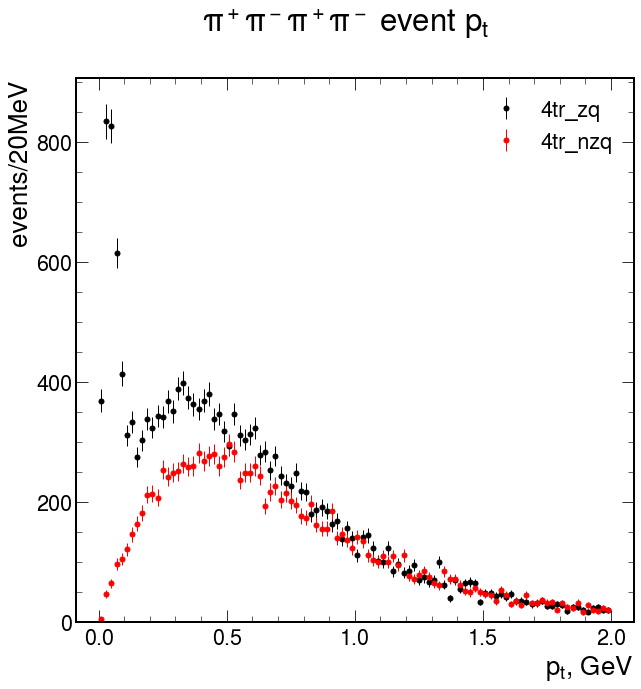

In [2]:
ErrorHist.DrawErrorHists([pt_events(data.four_tracks_zq), pt_events(data.four_tracks_nzq)], bins=100, range=(0,2), title=f'$\pi^+\pi^-\pi^+\pi^-$ event $p_t$', x_label=['$p_t$, GeV', '$p_t$, GeV'], y_label=['events', 'events'], label = ['4tr_zq', '4tr_nzq'], color=['black', 'red'])

C:\Users\bdrum\AppData\Roaming\Python\Python39\site-packages\mplhep\plot.py:238: RuntimeWarning: invalid value encountered in sqrt
  _yerr = np.sqrt(h)


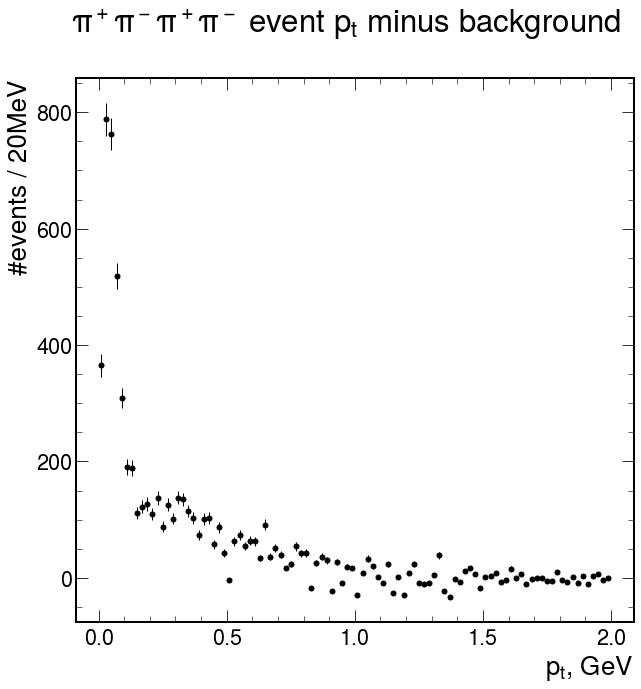

In [25]:
# %matplotlib widget
plt.style.use(hep.style.ROOT)
b = 100
r=(0,2)
counts, bin_edges = np.histogram(pt_events(data.four_tracks_zq), bins=b, range=r)
counts_bckg, bin_edges_bckg = np.histogram(pt_events(data.four_tracks_nzq), bins=b, range=r)

hep.histplot((counts-counts_bckg, bin_edges), yerr=True, color='black', histtype='errorbar')
ax = plt.gca()
plt.gcf().suptitle(f'$\pi^+\pi^-\pi^+\pi^-$ event $p_t$ minus background')
val=(r[1]-r[0])*1000 // b
ax.set_xlabel('$p_t$, GeV')
_ = ax.set_ylabel(f'#events / {val}MeV')


## Analysis cuts

### Global tracks

It's known that global tracks consist from ITS and TPC identification, in our case we can implicitly add checks for TPC identification track and see what happens with the data.

Let's aply further conditions for the tracks:

* |NumberOfSigmaTPCPion| < 3
* Number of TPC Clusters > 50
* TPCRefit

## Low energy tracks and TPC

There is an idea about that tracks with small energies (low pt) not able to reach TPC.
Idea is that addding such condition will decrease our signal and background level.



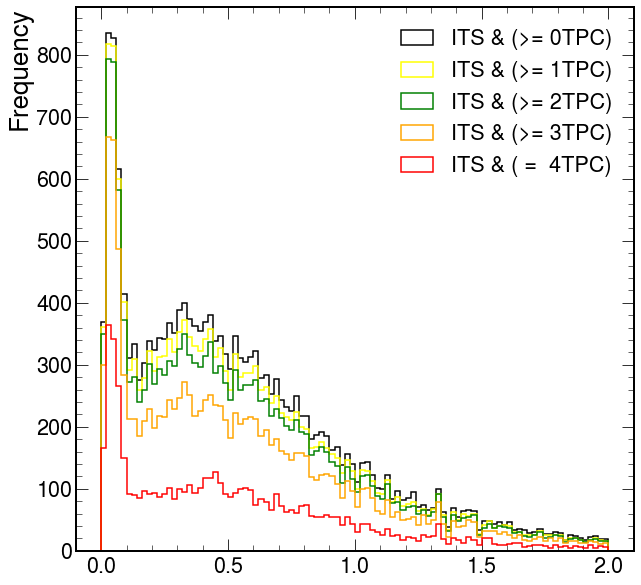

In [4]:
plt.style.use(hep.style.ROOT)
colors = ['black', 'yellow', 'green', 'orange', 'red']
labels = ['ITS & (>= 0TPC)', 'ITS & (>= 1TPC)',
          'ITS & (>= 2TPC)', 'ITS & (>= 3TPC)', 'ITS & ( =  4TPC)']

pts = []
for i in range(5):
    pts.append(pt_events(tpc.GetTracksWithNTPC(data.four_tracks_zq,i)))
    pts[i].name = labels[i]

df = pd.concat(pts,axis=1)
_ = df.plot(kind='hist', bins=100,range=(0,2), histtype='step', linewidth=1.5, color=colors, label=labels)


As we can see above adding of gobal tracks will decrease statistics level, but it is correct for both signal and background. Let's estimate what number of global tracks in 4 tracks is enough:

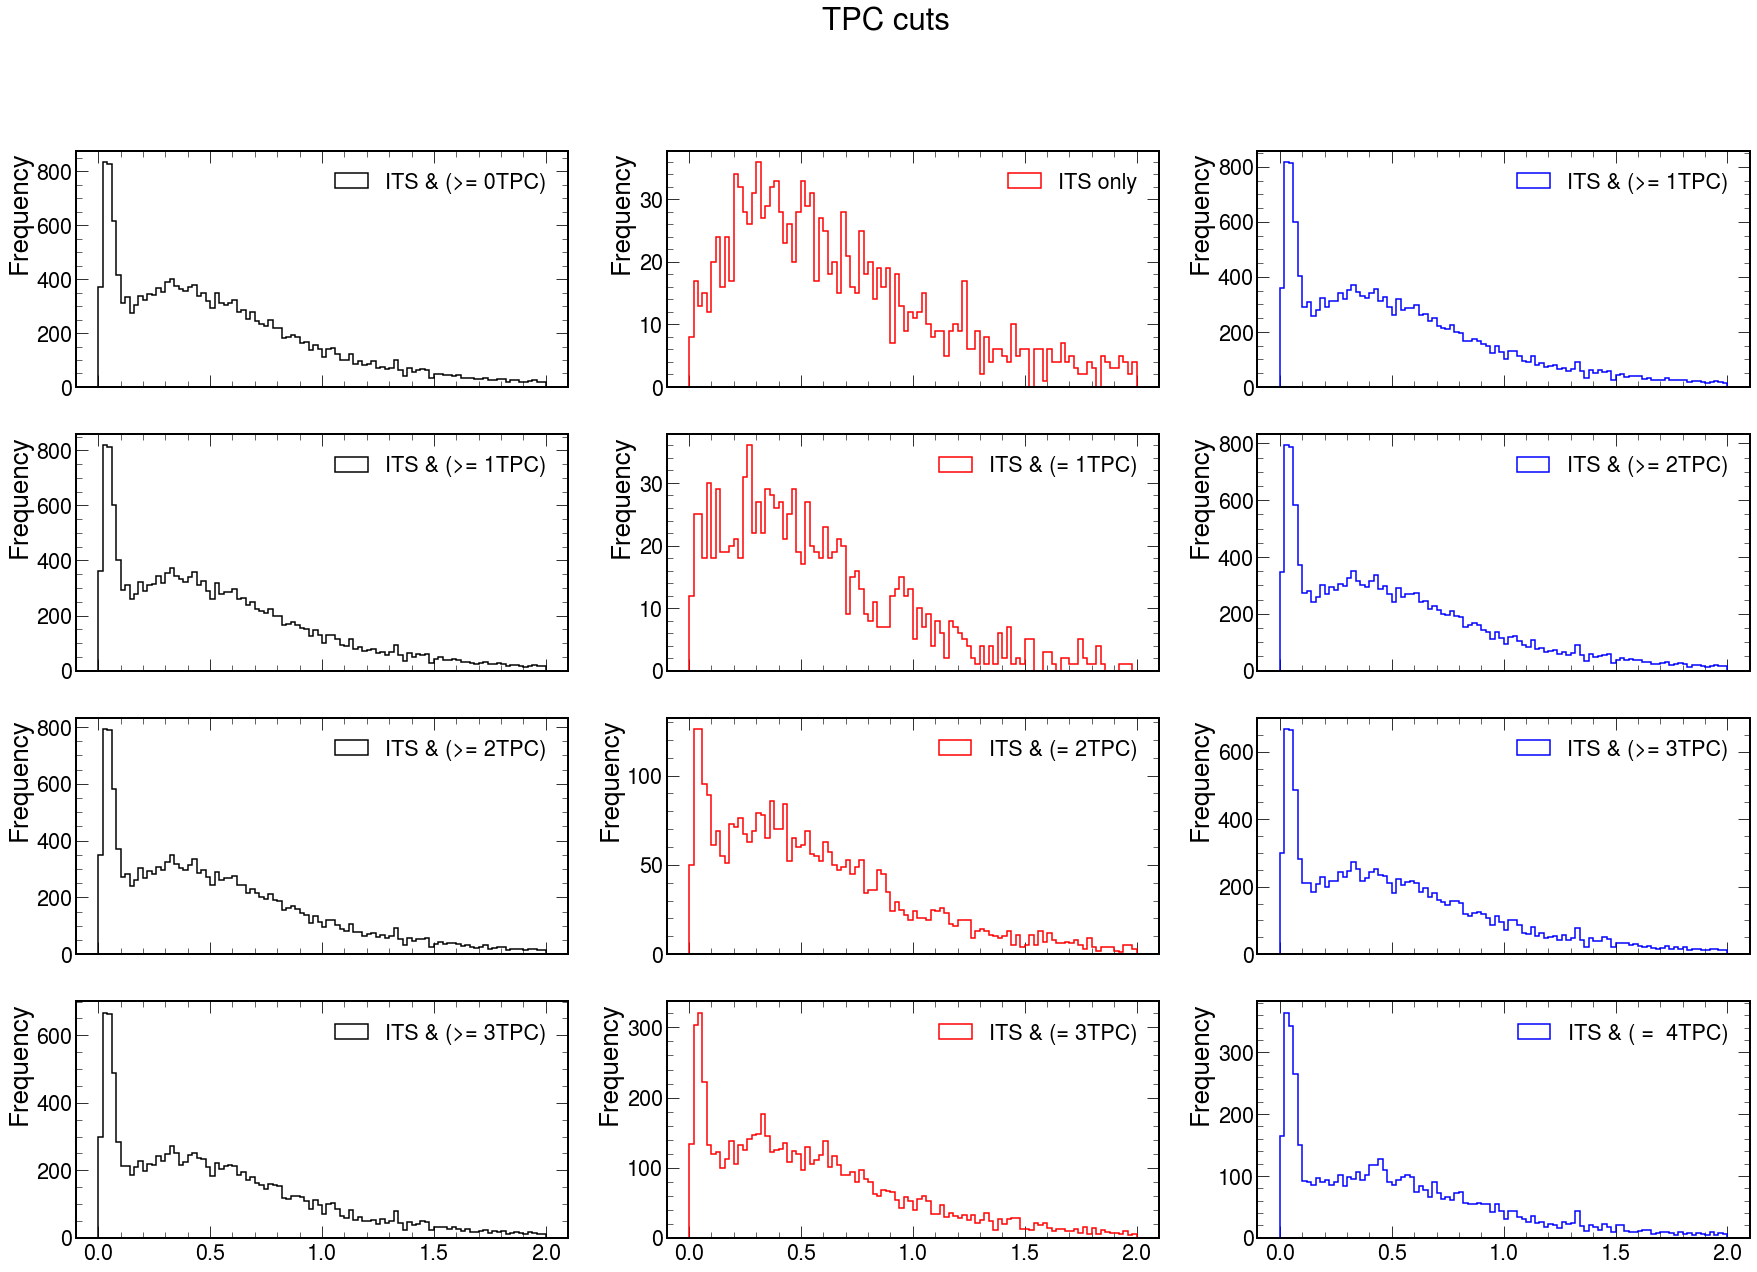

In [5]:
# %matplotlib widget

ptdiff = []
for i in range(1,5):
    ptdiff.append(pts[i-1][pts[i-1].index.difference(pts[i].index)])

ptdiff[0].name = 'ITS only'
ptdiff[1].name = 'ITS & (= 1TPC)'
ptdiff[2].name = 'ITS & (= 2TPC)'
ptdiff[3].name = 'ITS & (= 3TPC)'

df = pd.concat([pts[0], ptdiff[0], pts[1], pts[1], ptdiff[1], pts[2], pts[2], ptdiff[2], pts[3], pts[3], ptdiff[3], pts[4]],axis=1)
_ = df.plot(kind='hist', bins=100,range=(0,2), histtype='step', linewidth=1.5, color=['black','red','blue'], subplots=True, layout=(4,3), figsize=(30,20), title='TPC cuts')

Here we see such construction each row contains three plots:
 - starting point or what we have (first cell correspond our initial plot at the very begining of this notebook)
 - what we will throw
 - the difference between 1 and 2

 As we can see in case of transition from zero global tracks to one we will lose only background.
 I guess it's easy to see that the best case when we throw almost only background event is more than 2 global tracks in event.

 In further analysis I will be use this case. 'ITS & (>= 2TPC)'

## False triggering

There are some situations when CCUP9 trigger could be fired false:
It may occured when some fake or random track fires FOR and trigger will provide.

We can check list of FORs of event and what chipkey has each of four tracks.
In case it has matches and produce back to back topology this means correct trigger state.

![img](https://sun9-58.userapi.com/impf/x7UtIW5ElLKpDl4ASPuz0FXhNjwnxYcAy0BuHw/wJZr1On9l4o.jpg?size=1280x718&quality=96&sign=1ed3d5f08fcdefd89ab4e02a5041c6d0&type=album)

See debugging details in [one of the issue](https://github.com/bdrum/cern-physics/issues/42)


Let's do the same thing as we do few cell above and let's try to understand what we will throw after splitting event by fake triggered or not:

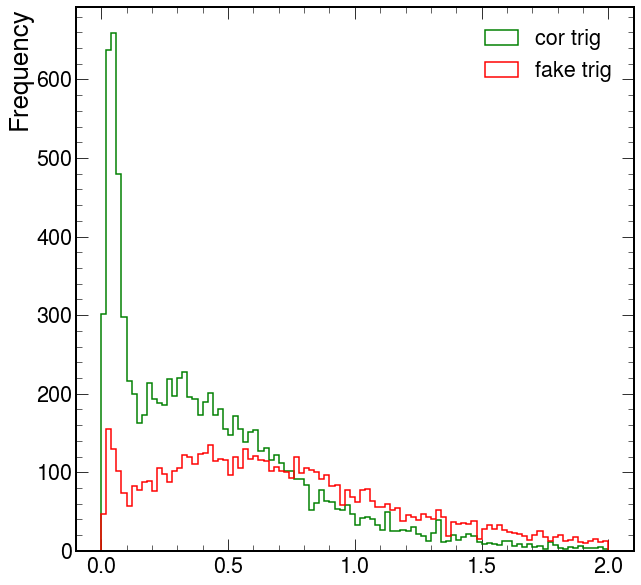

In [6]:
pt2_trig = pts[2][pts[2].index.intersection(trig)]
pt2_trig.name = 'cor trig'
pt2_untrig = pts[2][pts[2].index.intersection(untrig)]
pt2_untrig.name = 'fake trig'
df = pd.concat([pt2_trig,pt2_untrig],axis=1)
_ = df.plot(kind='hist', bins=100,range=(0,2), histtype='step', linewidth=1.5, color=['green','red'], subplots=False,label=['1','2'])


Let's see how looks masses for correct and fake trigger events:

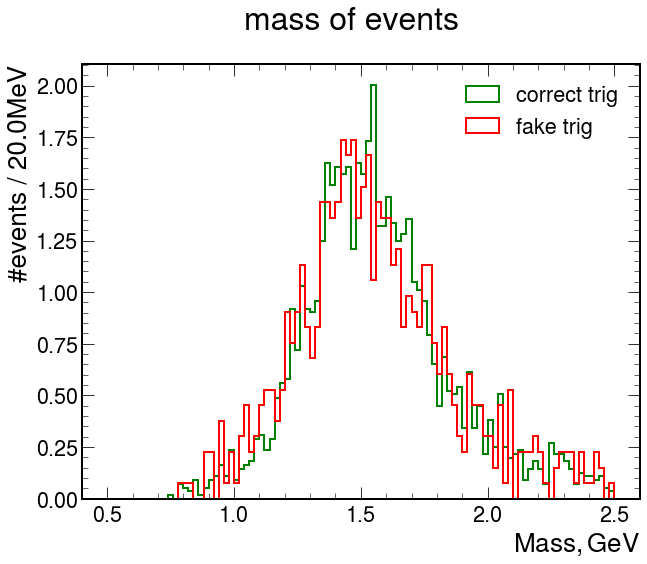

In [7]:
# %matplotlib widget
fig = plt.figure(figsize=(10,8))
ax= fig.add_subplot()

fig.suptitle('mass of events', fontsize=32)
b = 100
r = 0.5,2.5

cnts, bins, _ = ax.hist(mass_events(kinematics.GetTracksWithPtCut(four_tracks_zq_trig)),bins=b, range=r,histtype='step', linewidth=2,  color='green', density=True, label='correct trig')

_ = ax.hist(mass_events(kinematics.GetTracksWithPtCut(four_tracks_zq_untrig)),bins=b, range=r,histtype='step', linewidth=2, density=True, label='fake trig', color='red')

val=(r[1]-r[0])*1000 // b
ax.set_xlabel('$Mass, GeV$')
ax.set_ylabel(f'#events / {val}MeV')

_ = ax.legend()

As we can see above the shape of masses for fake trigger and correct trigger the same. Here we use pdf view for a normalization purposes. Despite of this fact we saw on $p_t$ distribution that fake triggers contains signal part, but most of the fake trigger data is bacgrkound events.

In further analysis we will use only correct trigger events. Also we hope that it will make our data closer to MC quality.

## ZDC cuts

ZDC again allows us to make signal more clear. Neutrons in ZDC could be a markers about peripheral events. 

No handles with labels found to put in legend.


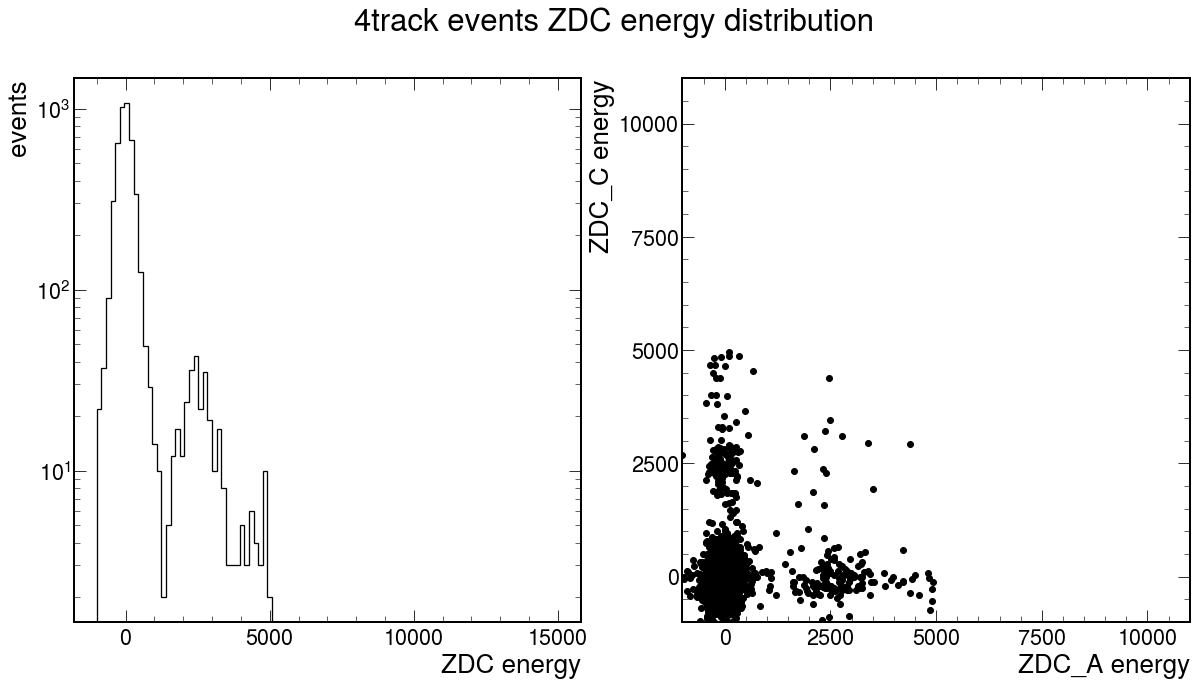

In [8]:
# %matplotlib widget

zdcEnA = data.orig_events.ZNAenergy[ft_zq_ac_pt_cut_indexes]
zdcEnC = data.orig_events.ZNCenergy[ft_zq_ac_pt_cut_indexes]
zdcEn = np.concatenate((zdcEnA, zdcEnC))
plt.subplots(1,2,figsize=(20,10))
plt.suptitle('4track events ZDC energy distribution')
plt.sca(plt.gcf().axes[0])
cnt = plt.hist(zdcEn, bins=100, range=(-1000,15000), histtype='step', linewidth=1.3, color='black')
plt.xlabel('ZDC energy')
plt.ylabel('events')
plt.yscale('log')

plt.sca(plt.gcf().axes[1])
_ = plt.scatter(zdcEnA, zdcEnC, color='black')
plt.xlabel('ZDC_A energy')
plt.ylabel('ZDC_C energy')
plt.xlim(-1000, 11000)
plt.ylim(-1000, 11000)
plt.xticks(np.arange(0,11000,2500))
plt.yticks(np.arange(0,11000,2500))
# plt.suptitle('4track events ZDC_A vs ZDC_C scatter')
_ = plt.legend()



Beside energy distirbution we also have to make corrections for ZDC timing:

No handles with labels found to put in legend.


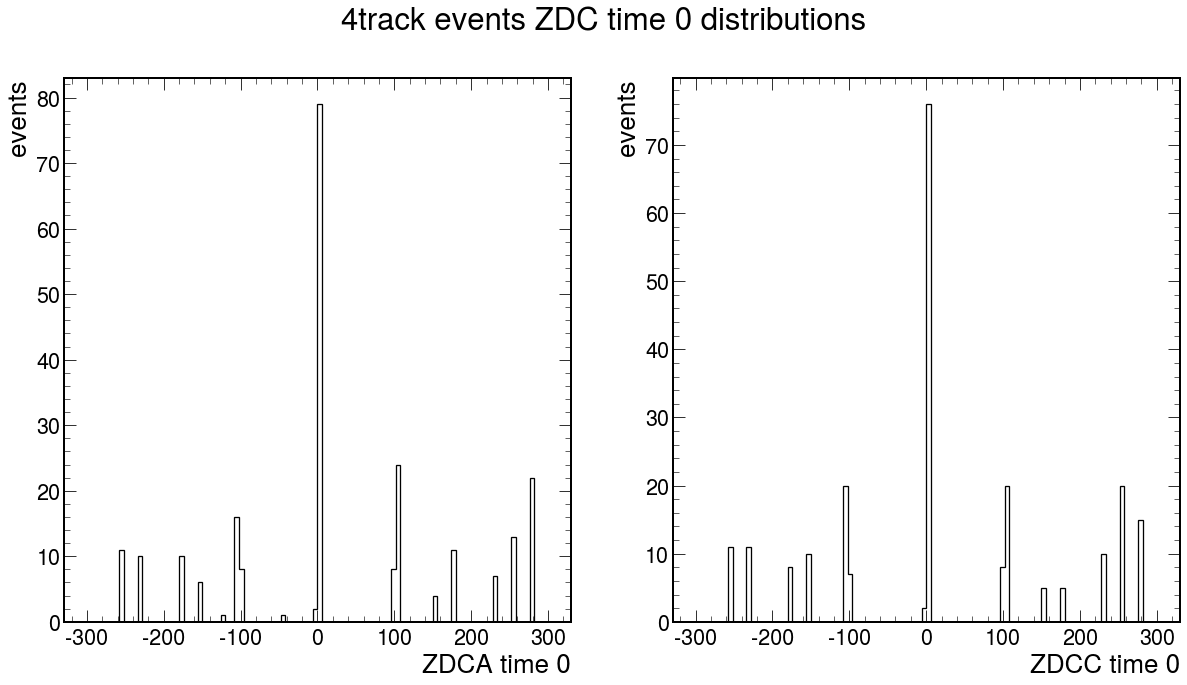

In [9]:
# %matplotlib widget

ZDCAtime_0 = data.orig_events.ZDCAtime_0[ft_zq_ac_pt_cut_indexes][data.orig_events.ZNAenergy[ft_zq_ac_pt_cut_indexes]<1000]
ZDCCtime_0 = data.orig_events.ZDCCtime_0[ft_zq_ac_pt_cut_indexes][data.orig_events.ZNCenergy[ft_zq_ac_pt_cut_indexes]<1000]
plt.subplots(1,2,figsize=(20,10))
plt.suptitle('4track events ZDC time 0 distributions')
plt.sca(plt.gcf().axes[0])
cnt = plt.hist(ZDCAtime_0, bins=100, range=(-300,300), histtype='step', linewidth=1.3, color='black')
plt.xlabel('ZDCA time 0')
plt.ylabel('events')

plt.sca(plt.gcf().axes[1])
cnt = plt.hist(ZDCCtime_0, bins=100, range=(-300,300), histtype='step', linewidth=1.3, color='black')
plt.xlabel('ZDCC time 0')
plt.ylabel('events')
_ = plt.legend()


Event called passed ZDC cuts if satisfied such criteria:
- For only one of the two sides
- neutrons energy less or equal than given parameter ZDC_En value
- or
- one of ZDC times not in an interval of +- ZDC_Time_Delta parameter value 

,count,mean,std,min,25%,50%,75%,max
ZDC < 5TeV | abs(ZDC_times) >100,6605.0,0.408039,2.210536,0.000275,0.071012,0.281112,0.548197,176.975204
ZDC > 5TeV & abs(ZDC_times) <=100,3032.0,0.596154,0.887427,0.002845,0.259760,0.495125,0.785955,42.316540


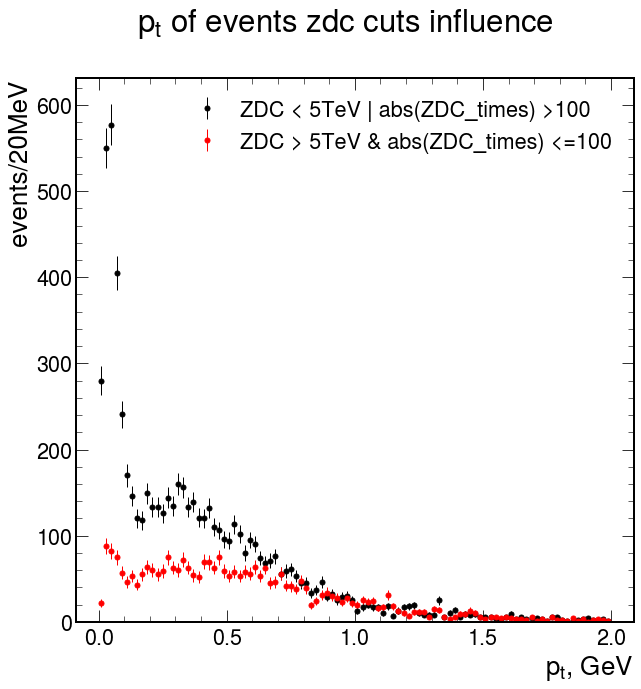

In [10]:
ErrorHist.DrawErrorHists([pt_events(four_tracks_zq_after_all_cuts), pt_events( four_tracks_zq_not_passed_zdc )], bins=100, range=(0,2), title=f'$p_t$ of events zdc cuts influence', x_label=['$p_t$, GeV', '$p_t$, GeV'], y_label=['events', 'events'], label = ['ZDC < 5TeV | abs(ZDC_times) >100', 'ZDC > 5TeV & abs(ZDC_times) <=100'], color=['black', 'red'])

## Transversal momentum distribution after all cuts


,count,mean,std,min,25%,50%,75%,max
orig $p_t$,19456.0,0.837667,12.995872,0.000275,0.215188,0.483686,0.846086,1726.771484
$p_t$ all cuts,6605.0,0.408039,2.210536,0.000275,0.071012,0.281112,0.548197,176.975204


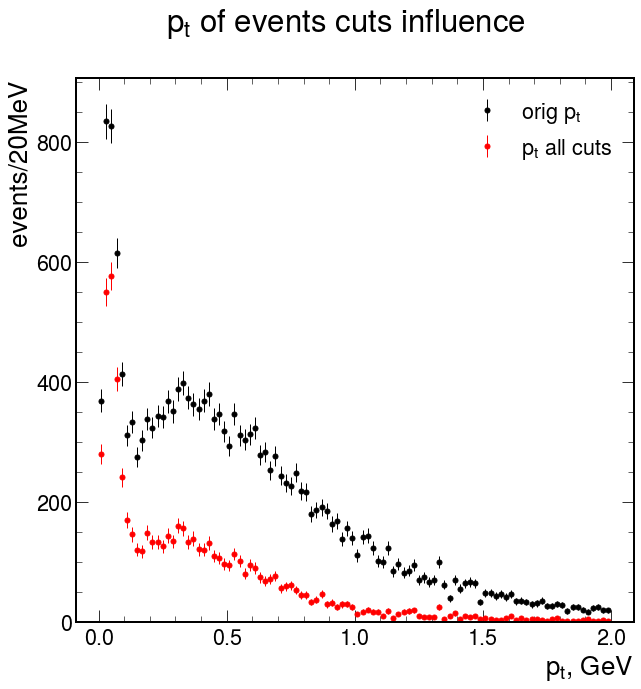

In [11]:
ErrorHist.DrawErrorHists([pt_events(data.four_tracks_zq), pt_events(four_tracks_zq_after_all_cuts)], bins=100, range=(0,2), title=f'$p_t$ of events cuts influence', x_label=['$p_t$, GeV', '$p_t$, GeV'], y_label=['events', 'events'], label = ['orig $p_t$', '$p_t$ all cuts'], color=['black', 'red'])

Now  let's try to see what tracks we lost from signal area and what contribution they have:

TPC and ITS has different coverage for polar angle:

![img1](https://camo.githubusercontent.com/9a7ab40d0f74a866a7095986644134a0f72cc58b/68747470733a2f2f70702e757365726170692e636f6d2f633835323231362f763835323231363738332f3131396137332f304f76685f6c544b4e7a552e6a7067)

Perhaps we have tracks that not only can't reach TPC, but also has $\theta$ values that TPC doesn't cover.

Below we can see polar angle distribution for tracks that covers three cases:

1. All tracks from events were reconstructed by ITS and TPC
2. Only ITS tracks from events with only part TPC tracks. Here tracks that not reconstructed by TPC
3. All tracks from events were reconstructed by ITS or TPC

We can see small gaps with for the second case, that allow to speak about correctness of the suggestion, but anyway low energy of tracks is the main reason why TPC can't reconstructed tracks.  

## Mass
Let's see on the mass distribution of the events


,count,mean,std,min,25%,50%,75%,max
ft_zq_all_cuts,2418.0,1.613113,0.390436,0.740946,1.383315,1.549550,1.747386,4.907002
ft_nzq_pt_cut,663.0,1.413462,0.563853,0.637530,0.978157,1.344274,1.708745,4.250375


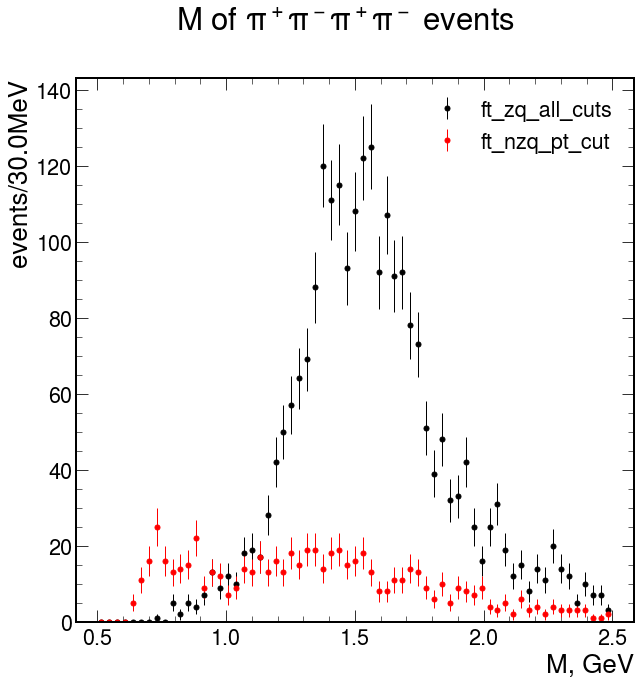

In [12]:
mass_after_all_cuts = mass_events(kinematics.GetTracksWithPtCut(four_tracks_zq_after_all_cuts))
mass_nzq = mass_events(kinematics.GetTracksWithPtCut(data.four_tracks_nzq))
ErrorHist.DrawErrorHists([mass_after_all_cuts, mass_nzq], bins=65, range=(0.5,2.5), title=f'$M$ of $\pi^+\pi^-\pi^+\pi^-$ events', x_label=['M, GeV', 'M, GeV'], y_label=['events', 'events'], label = ['ft_zq_all_cuts', 'ft_nzq_pt_cut'], color=['black', 'red'])

### Pions subsystems

In our process 4 pions were producted. The most probably intermediate state including two pions and $\rho$ i.e.
$$\rho' \rightarrow \rho \ \pi^+ \pi^- \rightarrow \pi^+ \pi^- \pi^+ \pi^-$$ 

We can see this on distribution of mass that can be obtained as all combinations of pairs from intial four tracks, i.e. only four pairs:

![img](https://camo.githubusercontent.com/53a52e2a6d4ae7112d74f4073c979a51166170d8/68747470733a2f2f70702e757365726170692e636f6d2f633835333632342f763835333632343436372f34383466332f5431375a754b597062526f2e6a7067)

Here we can plot two distirbutions:

1. Make all possible(4) combinations of pairs. Then take lightest and pair that belong to one combination with that. Plot masses of these two pairs.
2. Plot masses of masses from possible combinations.

In [13]:
from FourTracks.analysis import pairs
tracks  = kinematics.GetTracksWithPtCut(four_tracks_zq_after_all_cuts)
PosFirstTrack = tracks[tracks.T_Q > 0].reset_index().groupby('entry').first()
PosSecTrack = tracks[tracks.T_Q > 0].reset_index().groupby('entry').last()
NegFirstTrack = tracks[tracks.T_Q < 0].reset_index().groupby('entry').first()
NegSecTrack = tracks[tracks.T_Q < 0].reset_index().groupby('entry').last()

## first comb
pair1 = pairs.MakePair(PosFirstTrack, NegFirstTrack)
pair2 = pairs.MakePair(PosSecTrack, NegSecTrack)
## second comb
pair3 = pairs.MakePair(PosFirstTrack, NegSecTrack)
pair4 = pairs.MakePair(PosSecTrack, NegFirstTrack)

## background
pair_bckg_pos = pairs.MakePair(PosFirstTrack, PosSecTrack)
pair_bckg_neg = pairs.MakePair(NegFirstTrack, NegSecTrack)
heavy_pairs_bckg = pd.concat([mass_events(pair_bckg_pos), mass_events(pair_bckg_neg)], axis=1).max(axis=1)
rho_bckg_pos = mass_events(pair_bckg_pos)
rho_bckg_neg = mass_events(pair_bckg_neg)
# rho_bckg = pd.concat([mass_events(pair_bckg_pos), mass_events(pair_bckg_neg)])

# total pairs masses
heavy_pairs_1comb = pd.concat([mass_events(pair1), mass_events(pair2)], axis=1).max(axis=1)
light_pairs_1comb = pd.concat([mass_events(pair1), mass_events(pair2)], axis=1).min(axis=1)
heavy_pairs_2comb = pd.concat([mass_events(pair3), mass_events(pair4)], axis=1).max(axis=1)
light_pairs_2comb = pd.concat([mass_events(pair3), mass_events(pair4)], axis=1).min(axis=1)

total_heavy_pairs_masses = pd.concat([heavy_pairs_1comb,heavy_pairs_2comb])
total_light_pairs_masses = pd.concat([light_pairs_1comb,light_pairs_2comb])
total_heavy_pairs_masses.name = 'heavy'
total_light_pairs_masses.name = 'light'
# heavy-recoil pairs

,count,mean,std,min,25%,50%,75%,max
heavy,4836.0,0.812236,0.259066,0.291725,0.674686,0.778129,0.902377,3.544038
light,4836.0,0.525252,0.164924,0.279545,0.399250,0.498259,0.627641,2.129988


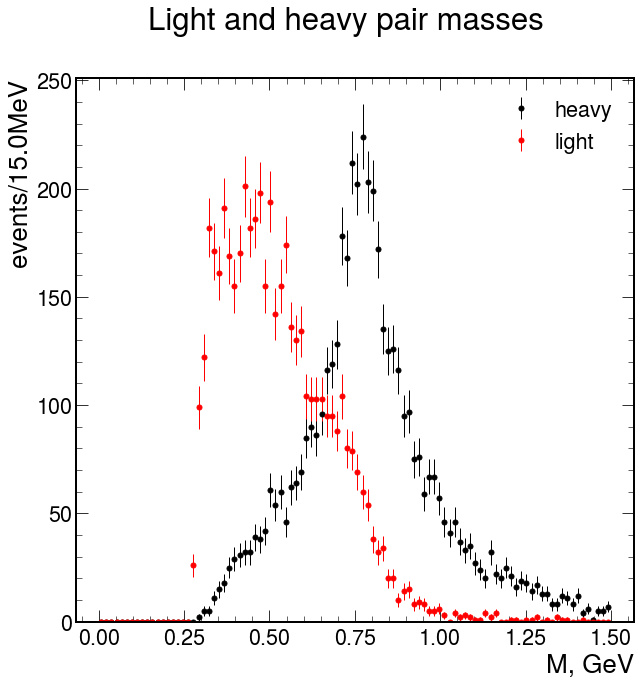

In [15]:
ErrorHist.DrawErrorHists([total_heavy_pairs_masses, total_light_pairs_masses], bins=100, range=(0,1.5), title='Light and heavy pair masses', x_label=['M, GeV', 'M, GeV'], y_label=['events', 'events'], label = ['heavy', 'light'], color=['black', 'red'])

As we can see above, for second case (all possible pairs) we've got stronger signal in comparison with light-recoil pair as it made in [STAR work](http://arxiv.org/abs/0912.0604v2). Let's build 2d distirbuition and marginals component separately:

No handles with labels found to put in legend.


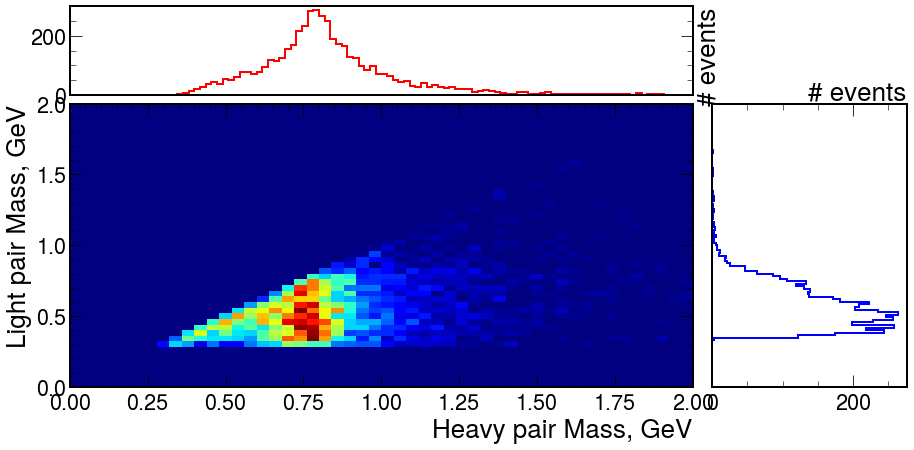

In [16]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 7))
gs = GridSpec(4,4,wspace=0.1,hspace=0.1)

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.hist2d(total_heavy_pairs_masses, total_light_pairs_masses, bins=(50, 50), range=[(0, 2), (0, 2)], cmap=plt.cm.jet)

_ = ax_marg_y.hist(total_light_pairs_masses, bins=100, range=(0, 2), histtype='step', color='blue', linewidth=2, label='lite pair',orientation="horizontal")

_ = ax_marg_x.hist(total_heavy_pairs_masses, bins=100, range=(0, 2), histtype='step', color='red', linewidth=2, label='rest pair')


ax_joint.set_ylabel('Light pair Mass, GeV')
ax_joint.set_xlabel('Heavy pair Mass, GeV')

# ax_marg_y.set_xlabel('$Mass, GeV$')
ax_marg_y.set_xlabel('# events')
ax_marg_x.yaxis.set_label_position("right")
ax_marg_x.xaxis.set_ticks([])
ax_marg_x.xaxis.set_ticks_position('none')
ax_marg_y.yaxis.set_ticks_position('none')
ax_marg_y.yaxis.set_ticks([])


# ax_marg_x.set_xlabel('$Mass, GeV$')
ax_marg_x.set_ylabel('# events')
ax_marg_y.xaxis.set_label_position("top")
ax_marg_x
_ = ax_joint.legend()
# fig

## Data modeling
First of all let's try to fit $\rho(0)$ that we can see as heavy pair of final 4 pions state:

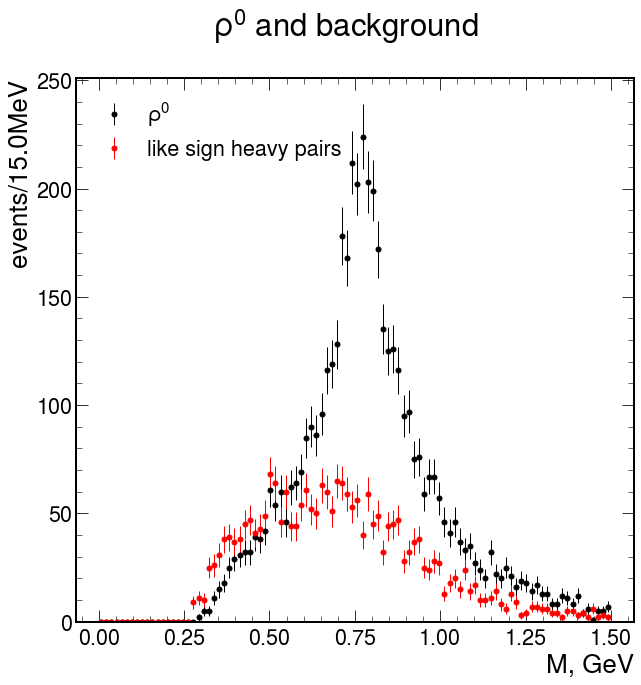

In [17]:
ErrorHist.DrawErrorHists([total_heavy_pairs_masses, heavy_pairs_bckg], bins=100, range=(0,1.5), title=r'$\rho^0$ and background', x_label=['M, GeV', 'M, GeV'], y_label=['events','events'], label =[r'$\rho^0$', 'like sign heavy pairs '] , color=['black', 'red'])

total_heavy_pairs_masses.to_csv(r"D:\GoogleDrive\Job\cern\Alice\analysis\data\RhoPrime\2015\heavy_pair_mass.csv")

mass_after_all_cuts.to_csv(r"D:\GoogleDrive\Job\cern\Alice\analysis\data\RhoPrime\2015\4pi_mass.csv")

d:\GoogleDrive\Job\cern\Alice\analysis\dev\physics\notebooks\FourTracks\analysis\fit.py:24: RuntimeWarning: invalid value encountered in sqrt
  q = np.sqrt((x ** 2) / 4 - pi_pl_mass ** 2)
d:\GoogleDrive\Job\cern\Alice\analysis\dev\physics\notebooks\FourTracks\analysis\fit.py:24: RuntimeWarning: invalid value encountered in sqrt
  q = np.sqrt((x ** 2) / 4 - pi_pl_mass ** 2)
[[Model]]
    (Model(bw_bckg, prefix='bw_') + Model(polynomial, prefix='bckg_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 98
    # variables        = 9
    chi-square         = 6005.22121
    reduced chi-square = 67.4743956
    Akaike info crit   = 421.310875
    Bayesian info crit = 444.575582
##  Warning: uncertainties could not be estimated:
    bw_G:         at initial value
    bw_amp:       at initial value
    bckg_c0:      at initial value
    bckg_c1:      at initial value
    bckg_c3:      at initial value
    bckg_c4:      at initial value
   

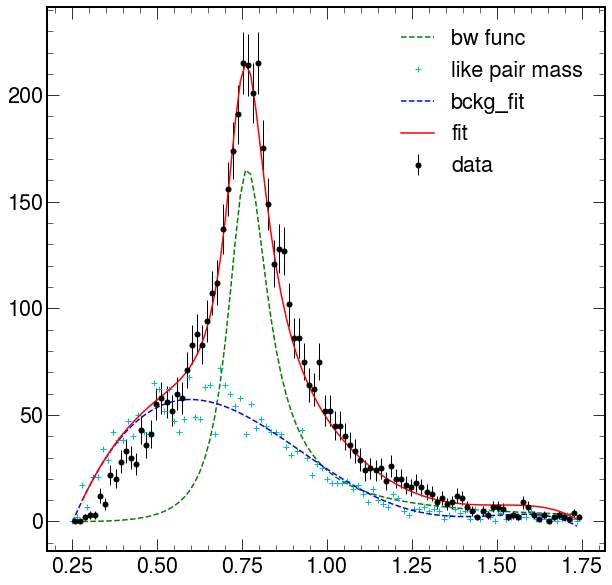

In [18]:
from lmfit import Model
from lmfit.models import BreitWignerModel, LinearModel, GaussianModel, ConstantModel, PolynomialModel
from FourTracks.analysis import fit

# %matplotlib widget
fig = plt.figure()
ax = fig.add_subplot()
b = 100
r = 0.25,1.75
y, x = np.histogram(total_heavy_pairs_masses, bins=b, range=r)
x_orig = x
x = x[:-1]

bcg_y, bcg_x = np.histogram(heavy_pairs_bckg, bins=b, range=r)
bcg_x = bcg_x[:-1]

fit.bckg_y = bcg_y

mod_bckg = PolynomialModel(degree=5)
par_bckg = mod_bckg.guess(bcg_y, x = bcg_x)
bckg_fit_res = mod_bckg.fit(bcg_y,par_bckg, x=bcg_x, nan_policy='omit')

mod = Model(fit.bw_bckg, prefix='bw_') + PolynomialModel(degree=5, prefix='bckg_')
pars = mod.make_params()

amp, M, G, amp_bckg = 165, 0.77, 0.15, 100

pars['bw_amp'].set(amp)
pars['bw_M'].set(M)
pars['bw_G'].set(G)
pars['bw_amp_bckg'].set(0, vary=False)
pars['bckg_c0'] = par_bckg['c0']
pars['bckg_c1'] = par_bckg['c1']
pars['bckg_c2'] = par_bckg['c2']
pars['bckg_c3'] = par_bckg['c3']
pars['bckg_c4'] = par_bckg['c4']
pars['bckg_c5'] = par_bckg['c5']

result = mod.fit(y,pars, x=x, nan_policy='omit')


print(result.fit_report())

hep.histplot((y, x_orig), yerr=True, color='black', histtype='errorbar', label='data')
ax.plot(x, fit.bw(x=x, M = M, G=G, amp=amp ), 'g--',label='bw func')
plt.plot(bcg_x, bcg_y, '+c', label='like pair mass')
plt.plot(bcg_x, bckg_fit_res.best_fit, 'b--', label='bckg_fit')
# plt.plot(x, result.init_fit, 'r--', label='init fit')
plt.plot(x, result.best_fit, 'r-', label='fit')
_ = plt.legend(loc='best')



[[Model]]
    (Model(bw_bckg, prefix='bw_') + Model(polynomial, prefix='bckg_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 65
    # variables        = 9
    chi-square         = 9415.11713
    reduced chi-square = 168.127092
    Akaike info crit   = 341.419500
    Bayesian info crit = 360.988985
##  Warning: uncertainties could not be estimated:
    bw_G:         at initial value
    bw_amp:       at initial value
    bckg_c0:      at initial value
    bckg_c1:      at initial value
    bckg_c2:      at initial value
    bckg_c4:      at initial value
    bckg_c5:      at initial value
[[Variables]]
    bw_M:         1.53480217 (init = 1.55)
    bw_G:         0.40000000 (init = 0.4)
    bw_amp:       110.000000 (init = 110)
    bw_amp_bckg:  0 (fixed)
    bckg_c0:     -140.522813 (init = -140.5228)
    bckg_c1:      545.656453 (init = 545.6565)
    bckg_c2:     -750.360538 (init = -750.3605)
    bckg_c3:      509.493396 (in

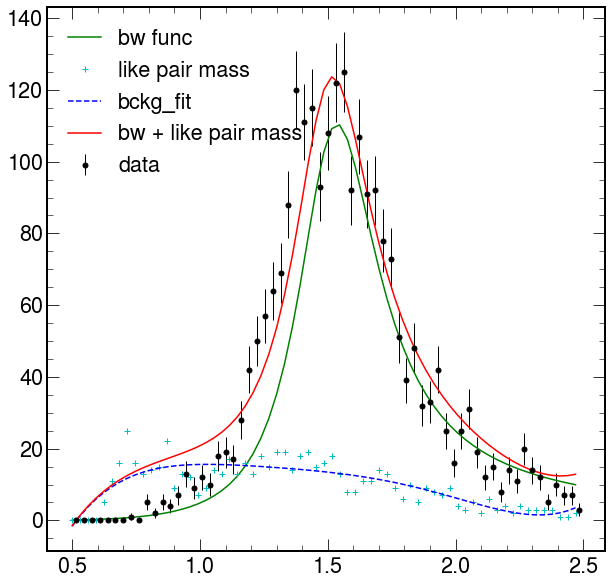

In [19]:
from lmfit import Model
from lmfit.models import BreitWignerModel, LinearModel, GaussianModel, ConstantModel, PolynomialModel
from FourTracks.analysis import fit

# %matplotlib widget

fig = plt.figure()
ax = fig.add_subplot()
b = 65
r = 0.5,2.5
y, x = np.histogram(mass_after_all_cuts, bins=b, range=r)
x_orig = x
x = x[:-1]

bcg_y, bcg_x = np.histogram(mass_nzq, bins=b, range=r)
bcg_x = bcg_x[:-1]

fit.bckg_y = bcg_y

mod_bckg = PolynomialModel(degree=5)
par_bckg = mod_bckg.guess(bcg_y, x = bcg_x)
bckg_fit_res = mod_bckg.fit(bcg_y,par_bckg, x=bcg_x, nan_policy='omit')

mod = Model(fit.bw_bckg, prefix='bw_') + PolynomialModel(degree=5, prefix='bckg_')
pars = mod.make_params()

amp, M, G, amp_bckg = 110, 1.55, 0.4, 0

pars['bw_amp'].set(amp)
pars['bw_M'].set(M)
pars['bw_G'].set(G)
pars['bw_amp_bckg'].set(amp_bckg, vary=False)
pars['bckg_c0'] = par_bckg['c0']
pars['bckg_c1'] = par_bckg['c1']
pars['bckg_c2'] = par_bckg['c2']
pars['bckg_c3'] = par_bckg['c3']
pars['bckg_c4'] = par_bckg['c4']
pars['bckg_c5'] = par_bckg['c5']
result = mod.fit(y,pars, x=x, nan_policy='omit')

print(result.fit_report())


hep.histplot((y, x_orig), yerr=True, color='black', histtype='errorbar', label='data')
ax.plot(x, fit.bw(x=x, M = M, G=G, amp=amp ), 'g-',label='bw func')
plt.plot(bcg_x, bcg_y, 'c+', label='like pair mass')
plt.plot(bcg_x, bckg_fit_res.best_fit, 'b--', label='bckg_fit')
plt.plot(x, result.best_fit, 'r-', label='bw + like pair mass')
plt.legend(loc='best')
plt.show()

[[Model]]
    ((Model(bw_bckg, prefix='bw1_') + Model(bw_bckg, prefix='bw2_')) + Model(polynomial, prefix='bckg_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 65
    # data points      = 65
    # variables        = 12
    chi-square         = 7381.36207
    reduced chi-square = 139.270982
    Akaike info crit   = 331.601203
    Bayesian info crit = 357.693850
##  Warning: uncertainties could not be estimated:
    bw1_M:         at initial value
    bw1_G:         at initial value
    bw1_amp:       at initial value
    bw2_M:         at initial value
    bw2_G:         at initial value
    bw2_amp:       at initial value
    bckg_c0:       at initial value
    bckg_c1:       at initial value
    bckg_c2:       at initial value
    bckg_c4:       at initial value
    bckg_c5:       at initial value
[[Variables]]
    bw1_M:         1.45000000 (init = 1.45)
    bw1_G:         0.30000000 (init = 0.3)
    bw1_amp:       90.0000000 (init = 90)
    bw1_amp_bc

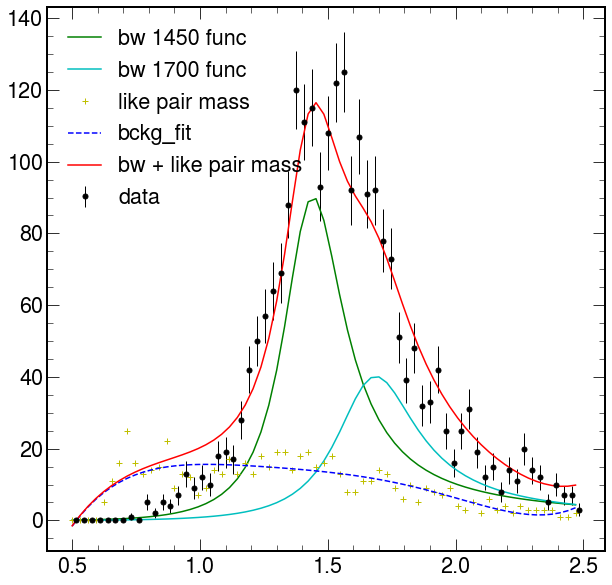

In [20]:
import matplotlib.pyplot as plt
from numpy import exp, loadtxt, pi, sqrt, random, histogram
from lmfit import Model
from lmfit.models import BreitWignerModel, LinearModel, GaussianModel, ConstantModel, PolynomialModel
from FourTracks.analysis import fit

# %matplotlib widget
fig = plt.figure()
ax = fig.add_subplot()

b = 65
r = 0.5,2.5
y, x = np.histogram(mass_events(kinematics.GetTracksWithPtCut(four_tracks_zq_after_all_cuts)), bins=b, range=r)
x_orig = x
x = x[:-1]

mod_bw = Model(fit.bw)

bcg_y, bcg_x = np.histogram(mass_events(kinematics.GetTracksWithPtCut(data.four_tracks_nzq)), bins=b, range=r)
bcg_x = bcg_x[:-1]

fit.bckg_y = bcg_y


mod_bckg = PolynomialModel(degree=5)
par_bckg = mod_bckg.guess(bcg_y, x = bcg_x)
bckg_fit_res = mod_bckg.fit(bcg_y,par_bckg, x=bcg_x, nan_policy='omit')

mod = Model(fit.bw_bckg, prefix='bw1_') + Model(fit.bw_bckg, prefix='bw2_') + PolynomialModel(degree=5, prefix='bckg_')
pars = mod.make_params()

amp1, M1, G1, amp_bckg1 = 90, 1.45, 0.3, 0
amp2, M2, G2, amp_bckg2 = 40, 1.7, 0.4, 0

pars['bw1_amp'].set(amp1)
pars['bw1_M'].set(M1)
pars['bw1_G'].set(G1)
pars['bw1_amp_bckg'].set(amp_bckg1, vary=False)

pars['bw2_amp'].set(amp2)
pars['bw2_M'].set(M2)
pars['bw2_G'].set(G2)
pars['bw2_amp_bckg'].set(amp_bckg2, vary=False)

pars['bckg_c0'] = par_bckg['c0']
pars['bckg_c1'] = par_bckg['c1']
pars['bckg_c2'] = par_bckg['c2']
pars['bckg_c3'] = par_bckg['c3']
pars['bckg_c4'] = par_bckg['c4']
pars['bckg_c5'] = par_bckg['c5']

result = mod.fit(y,pars, x=x) #, method='least_squares')

print(result.fit_report())

hep.histplot((y, x_orig), yerr=True, color='black', histtype='errorbar', label='data')
plt.plot(x, fit.bw(x=x, M = M1, G=G1, amp=amp1 ), 'g-',label='bw 1450 func')
plt.plot(x, fit.bw(x=x, M = M2, G=G2, amp=amp2 ), 'c-',label='bw 1700 func')
plt.plot(bcg_x, bcg_y, 'y+', label='like pair mass')
plt.plot(bcg_x, bckg_fit_res.best_fit, 'b--', label='bckg_fit')
plt.plot(x, result.best_fit, 'r-', label='bw + like pair mass')
plt.legend(loc='best')

## Decay angle for $\rho_0$

Here we would like to study angle decay for $\rho_0 \rightarrow \pi^+\pi^-$ between the momentum of one of the pions in the rest frame of $\rho_0$ and original(lab frame) momentum of  $\rho_0$.

For the sake of simplicity first we will create new lab system with OZ axis directed along momentum of $\rho_0$ in lab frame.

The transition from original lab frame to the new one could be obtain by two rotation:

- First, around x axis:

Rotation matrix for this case:
$$
R_{x,\alpha}=
\Bigg(
\begin{matrix}
1 & 0 & 0\\
0 & \cos{\alpha} & -\sin{\alpha} \\
0 & \sin{\alpha} & \cos{\alpha}
\end{matrix}
\Bigg)
$$

Rotation angle for x axis:

$$
\begin{matrix}
\sin{\alpha} =  \frac{p_y}{\sqrt{p_y^2+p_z^2}}  \\
\cos{\alpha} =  \frac{p_z}{\sqrt{p_y^2+p_z^2}}  \\
\end{matrix}
$$

Now, momentum vector of $\rho_0$ in this system will looks like

$$
\boldsymbol{p'}=R_{x,\alpha}\boldsymbol{p}=
\Bigg(
\begin{matrix}
p_x\\
p_y\cos{\alpha} - p_z\sin{\alpha}\\
p_y\sin{\alpha} + p_z\cos{\alpha})
\end{matrix}
\Bigg)
$$


- Second, around y axis:

Rotation matrix for this case will looks like
$$
R = R_{y,-\beta}= 
\Bigg(
\begin{matrix}
\cos{\beta} & 0 & -\sin{\beta}\\
0 & 1 & 0 \\
\sin{\beta} & 0 & \cos{\beta}
\end{matrix}
\Bigg)
$$

We have to apply it for already rotated vector around x axis:


$$
\boldsymbol{p''} =R_{y,-\beta}\boldsymbol{p'} = 
\Bigg(
\begin{matrix}
\cos{\beta} & 0 & -\sin{\beta}\\
0 & 1 & 0 \\
\sin{\beta} & 0 & \cos{\beta}
\end{matrix}
\Bigg)
\Bigg(
\begin{matrix}
{p'}_x\\
{p'}_y\\
{p'}_z
\end{matrix}
\Bigg)
 = 
\Bigg(
\begin{matrix}
{p'}_x\cos{\beta}-{p'}_z\sin{\beta}\\
{p'}_y\\
{p'}_x\sin{\beta}+{p'}_z\cos{\beta}
\end{matrix}
\Bigg)
$$


Where rotation angle based on the new rotated vector $\boldsymbol{p'}$ coordinates:

$$
\begin{matrix}
\sin{\beta}  =  \frac{{p'}_x}{\sqrt{{p'_x}^2+{p'}_z^2}}  \\
\cos{\beta}  =  \frac{{p'}_z}{\sqrt{{p'_x}^2+{p'}_z^2}}  \\
\end{matrix}
$$

As a result final transition looks like:
_____________
$$
\boldsymbol{p''} =
\Bigg(
\begin{matrix}
{p'}_x\cos{\beta}-{p'}_z\sin{\beta}\\
{p'}_y\\
{p'}_x\sin{\beta}+{p'}_z\cos{\beta}
\end{matrix}
\Bigg)=
\Bigg(
\begin{matrix}
p_x\cos{\beta}-p_y\sin{\alpha}\sin{\beta}-p_z\cos{\alpha}\sin{\beta} \\
p_y\cos{\alpha}-p_z\sin{\alpha} \\
p_x\sin{\beta}+p_y\sin{\alpha}\cos{\beta}+p_z\cos{\alpha}\cos{\beta}
\end{matrix}
\Bigg)
$$
where rotation angles are:


$$
\begin{matrix}
\sin{\alpha} =  \frac{p_y}{\sqrt{p_y^2+p_z^2}}  \\
\cos{\alpha} =  \frac{p_z}{\sqrt{p_y^2+p_z^2}}  \\
\sin{\beta}  =  \frac{p_x}{\sqrt{p_x^2+(p_y\sin{\alpha}+p_z\cos{\alpha})^2}}  \\
\cos{\beta}  =  \frac{p_y\sin{\alpha}+p_z\cos{\alpha}}{\sqrt{p_x^2+(p_y\sin{\alpha}+p_z\cos{\alpha})^2}}  \\
\end{matrix}
$$


Now let's consider moving coordinate system with $\rho_0$ so that OZ axis direct along $\boldsymbol{p}_{\rho_0}$

We know components of original momentum of $\pi^+$ in the such system and now let's boost their via Lorentz Transormation:

$$
\begin{matrix}
\ {E'} =  \gamma E - \Gamma p_z \\
\ {p'}_x= p_x \\
\ {p'}_y= p_y \\
\ {p'}_z= \gamma p_z - \Gamma E \\
\end{matrix}
$$

where 
$$ \boldsymbol{\beta} = \frac{\boldsymbol{p}}{E} $$
$$ \gamma = \frac{E}{m}$$
$$ \Gamma = \gamma \beta = \frac{p}{m}$$


$$ \boldsymbol{\beta} = \frac{\boldsymbol{p}}{E} $$
$$ \gamma = \frac{1}{\sqrt{1-\frac{p^2}{E^2}}}$$

Now the searched angle can be obtain from scalar multiplication of $\pi^+$ momentum in the rest frame of $\rho_0$ and momentum of $\rho_0$ in the lab frame:

$$\cos{\theta}=\frac{\boldsymbol{{p'}_{\pi^+}}\boldsymbol{p_{\rho_0}}} {{p'}_{\pi^+}p_{\rho_0}}$$

In [21]:
# %matplotlib widget

# tracks = heavy_pairs1[['T_Px', 'T_Py','T_Pz', 'T_Q']].sort_index()
# tracks_rho = tracks.groupby('entry').sum()
# tracks_pi_plus = tracks[tracks.T_Q>0].reset_index().drop('level_1',axis=1).set_index('entry')
# tracks_pi_min = tracks[tracks.T_Q<0].reset_index().drop('level_1',axis=1).set_index('entry')

# RotateToVector(rho, fir)
# RotateToVector(rho, sec)
# RotateToVector(tracks_rho, tracks_pi_plus)
# RotateToVector(tracks_rho, tracks_pi_min)
# BoostToSystem(rho.E/(0.001*Rho0.mass),rho.l/(0.001*Rho0.mass), fir)
# BoostToSystem(rho.E/(0.001*Rho0.mass),rho.l/(0.001*Rho0.mass), sec)
# BoostToSystem(tracks_rho.E/(0.001*Rho0.mass),tracks_rho.l/(0.001*Rho0.mass), tracks_pi_min)
# BoostToSystem(tracks_rho.E/(0.001*Rho0.mass),tracks_rho.l/(0.001*Rho0.mass), tracks_pi_plus)

# cost_lrnz_plus = CosTheta(tracks_pi_plus[['prx', 'pry', 'brpz']],tracks_rho[['T_Px', 'T_Py', 'T_Pz']])
# cost_lrnz_pvn = CosTheta(fir[['prx', 'pry', 'brpz']],rho[['T_Px', 'T_Py', 'T_Pz']])
# cost_pvn = CosTheta(fir[['T_Px', 'T_Py', 'T_Pz']],rho[['T_Px', 'T_Py', 'T_Pz']])
# cost = CosTheta(tracks_pi_plus[['T_Px', 'T_Py', 'T_Pz']],tracks_rho[['T_Px', 'T_Py', 'T_Pz']])


# lp_b_r_pi_plus = np.sqrt(tracks_pi_plus.prx**2 + tracks_pi_plus.pry**2 + tracks_pi_plus.brpz**2)

# tracks_pi_plus['cos_theta'] = (tracks_pi_plus.prx*tracks_rho.T_Px + tracks_pi_plus.pry*tracks_rho.T_Py + tracks_pi_plus.brpz*tracks_rho.T_Pz) / (lp_b_r_pi_plus*tracks_rho.l)

# _ = plt.hist(tracks_pi_plus.cos_theta,bins=100,range=(-1,1),histtype='step', linewidth=2, color='red', label=r"$\cos{{\theta}}$")

# tracks_pi_plus['cost_orig'] = (tracks_pi_plus.T_Px*tracks_rho.T_Px + tracks_pi_plus.T_Py*tracks_rho.T_Py + tracks_pi_plus.T_Pz*tracks_rho.T_Pz) / (tracks_pi_plus.lpr * tracks_rho.l)

# _ = plt.hist(tracks_pi_plus.cost_orig,bins=100,range=(-1,1),histtype='step', linewidth=2, color='black', label=r"$\cos{{\theta'}}$")
# _ = plt.legend()


## Cross section

Let's see to cross section of my events.

For this we should take luminosity of runs.

> Unfortunately file that I have to use for getting luminosity have a reference to special class AliTriggerInfo and moreover it packed into TObjArray, so I can't read it via uproot4. This is the reason why I used pure root again. [Here is the script](https://github.com/bdrum/cern-physics/blob/master/root-cpp/RhoPrime/macro/lumi.C) that I used.

Then let's see how much events do we have in each run.

$$L = \frac{1}{\sigma} \frac{\delta N}{\delta t}$$, this means that 

$$\sigma \approx \frac{N}{L}$$

Cross section of phenomena should be flat and independent from runs. 

Let's check it:

In [22]:
from FourTracks.analysis.crossection import GetCrossSection 
df_cs = GetCrossSection(data.orig_events.RunNum, kinematics.GetTracksWithPtCut(four_tracks_zq_after_all_cuts))
df_cs['sigma'] = df_cs.nEvFT / (df_cs.Lumi * 1000)

pdg_runs = [245145, 246148, 246217, 245963, 246424, 245683, 246036, 
        246487, 246808, 246804, 246271, 245146, 245151, 245152,
        245232, 245259, 245345, 245346, 245347, 245349, 245353,
        245396, 245397, 245401, 245407, 245409, 245410, 245411,
        245441, 245446, 245450, 245453, 245454, 245496, 245497,
        245501, 245504, 245505, 245507, 245540, 245542, 245543]

# df_cs['is_dpg']

df_cs.sigma.describe()



count    117.000000
mean       3.555185
std        1.101315
min        0.716081
25%        2.823498
50%        3.477399
75%        4.276723
max        6.551968
Name: sigma, dtype: float64

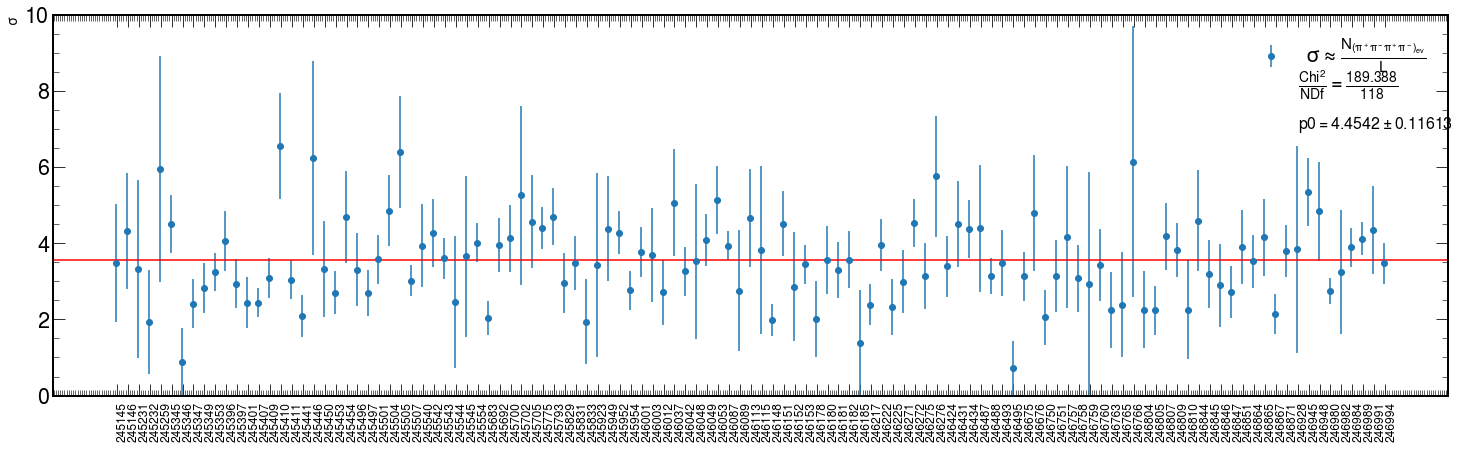

In [23]:
import scipy.stats
# %matplotlib widget
fig = plt.figure(figsize=(25, 7))
# fig.suptitle("visible cross section")
ax = fig.add_subplot()
bins = list(df_cs.run)
cnts = list(df_cs.sigma)
errs = np.sqrt(df_cs.nEvFT)/(df_cs.Lumi * 1000)
x = np.arange(len(bins))
width = 0.15
ax.errorbar(x - width/2, cnts, yerr=errs, fmt='o', label=r'$\sigma \approx \frac{N_{(\pi^+\pi^-\pi^+\pi^-)_{ev}}}{L}$')
ax.set_xticks(x)
ax.set_xticklabels(bins, rotation=90, rotation_mode="anchor", ha="right", fontsize=12)
ax.set_ylabel(r'$\sigma$',fontsize=14)
ax.set_ylim(0,10)

chi2,p = scipy.stats.chisquare(cnts, np.tile(np.average(cnts),len(cnts)))
ax.text(108,8,r"$\frac{Chi^2}{NDf} = \frac{189.388}{118}$", size=20)
ax.text(108,7,r"$p0 = 4.4542 \pm 0.11613$", size=16)
ax.legend(prop={'size': 15})
ax.axhline(y=np.average(cnts), color='r', linestyle='-')
_ = ax.legend()
# fig

## Other decays

In PDG I've seen also other interesting modes for $\rho'$:

- 1. $\rho' \rightarrow \eta_0 \rho_0$ | ?
   - 1.1. $\rho_0 \rightarrow 4 \pi$ | $2*10^{-5}\%$
   - 1.2. $\rho_0 \rightarrow \pi^+ \pi^-$ | $10^{-2}\%$
   - 1.3. $\eta_0' \rightarrow  \pi^+ \pi^- \gamma$ | $4\%$
   - 1.4. $\eta_0' \rightarrow  \pi^+ \pi^- \pi^0$ | $23\%$
- 2. $\rho' \rightarrow 4 \pi$ | ?

What if $\rho' \rightarrow \rho_0 \rho_0$ possible?